In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Concatenate, Conv1D, Activation, TimeDistributed, Flatten, RepeatVector, Permute,multiply
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, GRU, GlobalAveragePooling1D, MaxPooling1D, SpatialDropout1D, BatchNormalization
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.layers.core import K
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import matplotlib.pyplot as plt
%matplotlib inline

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16631629608964862674
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 10668300698
locality {
  bus_id: 1
}
incarnation: 14407953886703984601
physical_device_desc: "device: 0, name: Graphics Device, pci bus id: 0000:01:00.0"
]


#### some helper stuff for tracking performance over the duration of the project

In [2]:
def write_model_timestamp(model_type, kfolds, scores, note):
    '''
    Parameters:
    model_type = string description of the model(s) used to make these scores
    kfolds     = how many folds in kfold cross validation used
    scores     = list of ROC AUC avg scores of models for each class, floats should be like 0.9784
    note       = string, whatever is of note about the model, made a change or whatever
    
    Returns:
    None, but writes (appends) a line to scores.txt in the root directory so that progress can be tracked
    The format is:
            time(s)~model_type~kfold~avg_roc_auc~toxic_auc~s_toxic_auc~obscene_auc~threat_auc~insult_auc~i_hate_auc~notes
            
    scores.txt is a tilde '~' seperated CSV like:
        time~model_type~kfold~avg_roc_auc~toxic_auc~s_toxic_auc~obscene_auc~threat_auc~insult_auc~i_hate_auc~notes
        1520303252~0.9794005980274005~note something
    '''

    out_text = "{:10.0f}~{:}~{:2d}~{:0.8f}~{:0.8f}~{:0.8f}~{:0.8f}~{:0.8f}~{:0.8f}~{:0.8f}~{:}\n".format(time.time(), 
                                             model_type, 
                                             kfolds, 
                                             np.mean(scores),
                                             scores[0],
                                             scores[1],
                                             scores[2],
                                             scores[3],
                                             scores[4],
                                             scores[5],                                                
                                             note)
    
    with open("../scores.txt", 'a') as out_file:
        out_file.write(out_text)
        
        print("wrote:")
        print(out_text)
        print("to file")

#### Load data and light processing

In [3]:
train = pd.read_csv('../data/train.csv').fillna(' ')

train_labels = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
test = pd.read_csv('../data/test.csv').fillna(' ')

train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

#### Vectorize words from both corpora

In [4]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=50000)    # 10k was initial

word_vectorizer.fit(all_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [5]:
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

print("train shape:", train_word_features.shape)
print("test shape:", test_word_features.shape)

train shape: (159571, 50000)
test shape: (153164, 50000)


#### Make a neural net from scratch, what could possibly go wrong

In [13]:
def dnn_model(learning_rate=0.01, lr_decay=1e-6, drop_out=0.2, input_shape=(50000,)):
    
    DROPOUT = drop_out

    # Input
    _inputs = Input(shape=input_shape)

    # Try like 5 hidden layers starting big and getting small
    
    # maybe try kernel_initializer='he_normal' on dense layers
    X = Dense(256, activation="relu", name="dense_1")(_inputs)
    X = BatchNormalization()(X)
    X = Dropout(DROPOUT)(X)

    X = Dense(128, activation="relu", name="dense_2")(X)
    X = BatchNormalization()(X)
    X = Dropout(DROPOUT)(X)

    X = Dense(64, activation="relu", name="dense_3")(X)
    X = BatchNormalization()(X)
    X = Dropout(DROPOUT)(X)

    X = Dense(32, activation="relu", name="dense_4")(X)
    X = BatchNormalization()(X)
    X = Dropout(DROPOUT)(X)

    X = Dense(16, activation="relu", name="dense_5")(X)
    X = BatchNormalization()(X)
    X = Dropout(DROPOUT)(X)

    _outputs = Dense(6, activation='sigmoid', name="output_1")(X)

    # gather model
    model = Model(inputs=_inputs, outputs=_outputs, name="bad_dnn")
    
    # configure optimizer
    optimizer = Adam(lr=learning_rate, decay=lr_decay)
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])
    
    return model

def dnn_model2(learning_rate=0.01, lr_decay=1e-6, drop_out=0.2, input_shape=(50000,)):
    
    # take out about 10% of neurons per layer
    
    DROPOUT = drop_out

    # Input
    _inputs = Input(shape=input_shape)

    # Try like 5 hidden layers starting big and getting small
    
    # maybe try kernel_initializer='he_normal' on dense layers
    X = Dense(230, activation="relu", name="dense_1")(_inputs)
    X = BatchNormalization()(X)
    X = Dropout(DROPOUT)(X)

    X = Dense(115, activation="relu", name="dense_2")(X)
    X = BatchNormalization()(X)
    X = Dropout(DROPOUT)(X)

    X = Dense(58, activation="relu", name="dense_3")(X)
    X = BatchNormalization()(X)
    X = Dropout(DROPOUT)(X)

    X = Dense(29, activation="relu", name="dense_4")(X)
    X = BatchNormalization()(X)
    X = Dropout(DROPOUT)(X)

    X = Dense(14, activation="relu", name="dense_5")(X)
    X = BatchNormalization()(X)
    X = Dropout(DROPOUT)(X)

    _outputs = Dense(6, activation='sigmoid', name="output_1")(X)

    # gather model
    model = Model(inputs=_inputs, outputs=_outputs, name="bad_dnn")
    
    # configure optimizer
    optimizer = Adam(lr=learning_rate, decay=lr_decay)
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])
    
    return model
    
# https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x, batch_size=1024)
        
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val, batch_size=1024)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('roc-auc: %s - roc-auc_val: %s' % (str(round(roc,6)),str(round(roc_val,6))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

#### Use a single fold for experimentation since 10fold will take forever

In [10]:

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# for _class in class_names:
x_train, x_test, y_train, y_test = train_test_split(train_word_features, 
                                                    train_labels, 
                                                    test_size=0.1, 
                                                    random_state=1337)

print(x_train.shape)
print(class_names[3])

model = dnn_model(learning_rate=0.001, drop_out=0.50, input_shape=(x_train.shape[1],))
# print(model.summary())

hist = model.fit(x_train, y_train,
                batch_size=32,
                epochs=10,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=[roc_callback(training_data=(x_train, y_train),validation_data=(x_test, y_test))])

(143613, 50000)
threat
Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 78s 543us/step - loss: 0.1596 - binary_accuracy: 0.9418 - val_loss: 0.0672 - val_binary_accuracy: 0.9750
roc-auc: 0.970137 - roc-auc_val: 0.956728                                                                                                    
Epoch 2/10
143613/143613 [==============================] - 77s 535us/step - loss: 0.0763 - binary_accuracy: 0.9726 - val_loss: 0.0623 - val_binary_accuracy: 0.9765
roc-auc: 0.977081 - roc-auc_val: 0.963871                                                                                                    
Epoch 3/10
143613/143613 [==============================] - 77s 534us/step - loss: 0.0653 - binary_accuracy: 0.9767 - val_loss: 0.0613 - val_binary_accuracy: 0.9777
roc-auc: 0.980994 - roc-auc_val: 0.967371                                                                                                    
Epoch

In [17]:

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# for _class in class_names:
x_train, x_test, y_train, y_test = train_test_split(train_word_features, 
                                                    train_labels, 
                                                    test_size=0.1, 
                                                    random_state=1337)

print(x_train.shape)
print(class_names[3])

model = dnn_model2(learning_rate=0.001, drop_out=0.55, input_shape=(x_train.shape[1],))
# print(model.summary())

hist = model.fit(x_train, y_train,
                batch_size=32,
                epochs=10,
                verbose=1,
                validation_data=(x_test, y_test),
                callbacks=[roc_callback(training_data=(x_train, y_train),validation_data=(x_test, y_test))])

(143613, 50000)
threat
Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 77s 538us/step - loss: 0.1738 - binary_accuracy: 0.9395 - val_loss: 0.0682 - val_binary_accuracy: 0.9749
roc-auc: 0.967449 - roc-auc_val: 0.959945                                                                                                    
Epoch 2/10
143613/143613 [==============================] - 76s 527us/step - loss: 0.0829 - binary_accuracy: 0.9711 - val_loss: 0.0631 - val_binary_accuracy: 0.9770
roc-auc: 0.97607 - roc-auc_val: 0.964105                                                                                                    
Epoch 3/10
143613/143613 [==============================] - 77s 534us/step - loss: 0.0706 - binary_accuracy: 0.9747 - val_loss: 0.0632 - val_binary_accuracy: 0.9764
roc-auc: 0.979482 - roc-auc_val: 0.966265                                                                                                    
Epoch 

In [8]:
preds = model.predict(x_test)

percent_threat = np.sum(y_test == 1) / len(y_test) * 100.0
print("Threat:             {:05.2f}%".format(percent_threat))

Threat:             00.33%


In [1]:
print(y_test.shape)
print(preds.shape)

result = roc_auc_score(y_test, preds)

fpr = {}
tpr = {}
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# print(fpr)
print(result)

NameError: name 'y_test' is not defined

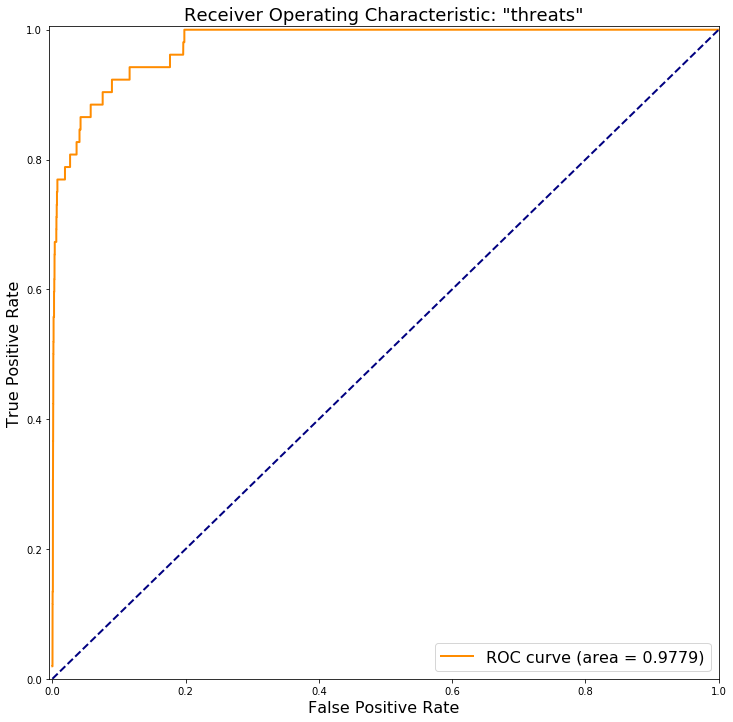

In [10]:
fig, ax = plt.subplots(figsize=(12,12))

ax.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.4f)' % roc_auc)


ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([-0.005, 1.0])
ax.set_ylim([0.0, 1.005])
ax.set_xlabel('False Positive Rate', size=16)
ax.set_ylabel('True Positive Rate', size=16)
ax.set_title('Receiver Operating Characteristic: "threats"', size=18)
ax.legend(loc="lower right", fontsize=16)
# plt.show()

In [20]:
y_pred1 = model.predict(test_word_features, batch_size=1024)

In [21]:
msubmission = pd.read_csv('../data/sample_submission.csv')
msubmission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred1
msubmission.to_csv('../submissions/tfidf_dnn_submission.csv.gz', index=False, compression="gzip")

In [22]:
file_name_base = "../models/dnn_model2"

model.save(file_name_base + ".h5")

# save as JSON
json_string = model.to_json()
json_out = file_name_base + ".json"

with open(json_out, "w") as outfile:
    outfile.write(json_string)